# Load some libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.measure as measure
from skimage import filters
from scipy import ndimage
%matplotlib inline

# Assignment

You have an image with round regions that you want to identify and create an image with only these features visible. In this assignment you will have to use knowledge from other assignments and all lectures.

1. Histograms
2. Filters
3. Thresholding
4. Cleaning
5. Labeling
6. Measure region properties
7. Classification based on abstract properties
8. Item extraction

## Load image
Load the image 'psi_slice_noisy.tif' and show it

(464, 464) 254.25 63.75


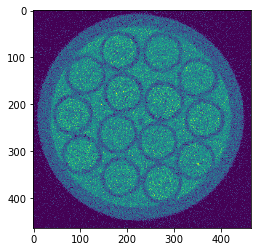

In [2]:
# img = 
img=np.mean(plt.imread('psi_slice_noisy.tif'),axis=2)
plt.imshow(img)
print(img.shape, np.max(img),np.min(img))

## Look at the histogram

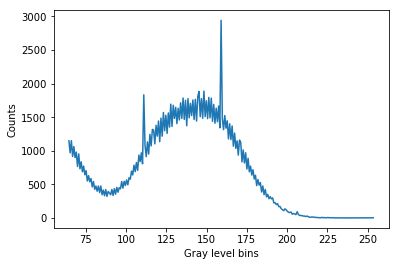

In [3]:
hist,ax=np.histogram(img,bins=250)
plt.plot(ax[1:-1], hist[1:])
plt.xlabel('Gray level bins')
plt.ylabel('Counts')

The image looks rather noisy... i.e. it has low SNR. Improve the SNR using a filter. Show the image and its histogram after filtering. The histogram is also incomplete on the left sie, i.e. the noise distribution is truncated.

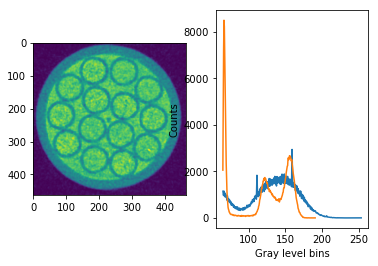

In [8]:
fimg=filters.gaussian(img,sigma=2)
plt.subplot(1,2,1)
plt.imshow(fimg)
plt.subplot(1,2,2)
fhist,fax=np.histogram(fimg,bins=250)
plt.plot(ax[1:-1], hist[1:],fax[1:-1], fhist[1:])
plt.xlabel('Gray level bins')
plt.ylabel('Counts')

Get a threshold using an automatic method provided by SciKit Image and apply to the image

The threshold according to 105.380898358


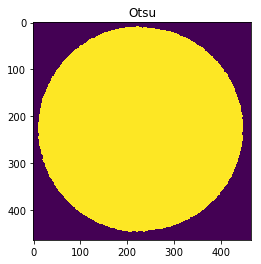

In [70]:
otsu = filters.threshold_otsu(fimg)
print('The threshold according to',otsu)
bimg=otsu<fimg
plt.imshow(bimg)
plt.title('Otsu')

As you see this threshold only separates background from sample. What we need is to compute the threshold from the sample pixels only. The function below helps you doing this.

In [28]:
def maskedOtsu(img,mask) :
    data=[]
    dims=img.shape
    for r in np.arange(0,dims[1]) :
        for c in np.arange(0,dims[0]) :
            if (mask[r,c]!=0) :
                data.append(img[r,c])
            
    ndata=np.asarray(data)
    return filters.threshold_otsu(ndata)


Use the previous bi-level image as mask and find a useful threshold with maskedOtsu. 

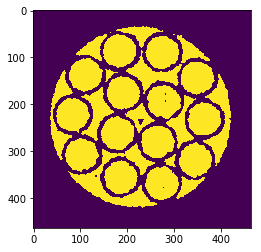

In [30]:
otsu2=maskedOtsu(fimg,bimg)
bimg2=otsu2<fimg

plt.imshow(bimg2)

In bimg2 some pixels are misclassified. Use morphological operation to clean this.

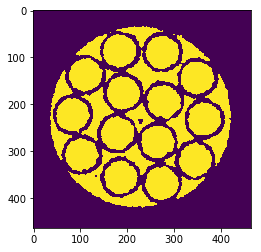

In [33]:
clean=morph.closing(bimg2,morph.square(3))
plt.imshow(clean)

## Labeling

Now, the image is ready to label. For this you have two choices connected pixels labeling or watershed. Which makes more sense here?

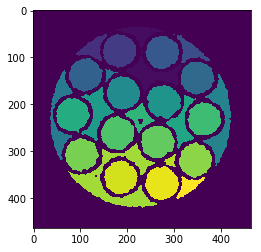

In [36]:
lbl=morph.label(clean)
plt.imshow(lbl)

No matter which method you chose. More regions than the round ones are labeled. We have to find a method to classify which ones we want to keep.

## Identify the discs

The first step is to measure some properties of different items. Use the library scikit.image function region properties to make measurements on the segmented regions.

http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops  

Select pairs of scalar properties and decide if they help you to identify the disks.

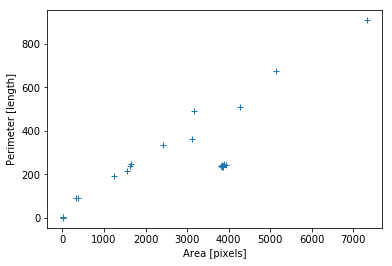

In [49]:
m=measure.regionprops(lbl)
p1=[]
p2=[]
for prop in m:
    p1.append(prop.area)
    p2.append(prop.perimeter)
    
plt.plot(p1,p2,'+')
plt.xlabel('Property 1')
plt.ylabel('Property 2')

Selecting the item is done by applying thresholds on each property. Is done in the function below. Plese complete the test in the function  

In [54]:
def selectItems(m,p1,p2,th1,th2) :
    selection = []
    for i in np.arange(0,len(p1)) :
        if ((th1<p1[i]) & (p2[i]<th2)) : # here you may have to modify the tests
            selection.append(m[i])
            
    return selection

In [68]:
# Enter you thresholds here to test if the function works
th1=3500
th2=350
selection=selectItems(m,p1,p2,th1,th2) 
print('Found 14 items',len(selection)==14)

Found 14 items True


## Extract the disks

Morphological reconstruction is a method to extract the regions. For this to work you need to create a marker image using the positons of the disks. The marker is zero valued except on the centroids of each disk which has the value of disk label.

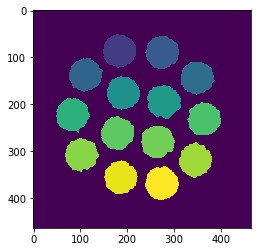

In [69]:
marker=np.zeros(lbl.shape)

for prop in selection :
    x=np.round(prop.centroid[0]).astype(int)
    y=np.round(prop.centroid[1]).astype(int)
    marker[x,y]=lbl[x,y]
    
final=morph.reconstruction(marker,lbl)
plt.imshow(final)